In [15]:
#!pip install transformers==4.26.0
#!pip install torchmetrics[detection]
#!pip install huggingface_hub --upgrade
#!pip install timm
#!pip install tf-nightly
#!pip install opencv-python


#### Animal Classification

This contains Two parts:

Animal classification using Keras.Sequential model. Animal classification by using transfer learning 

#### First Part

This part is basically the basic structure for someone to gain practical experience with following concepts":

Efficient loading a dataset off disk Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout. It also covers a basic machine learining workflow:

Examine and understand data
Build an input pipeline
Build the model
Train the model
Test the model
Improve the model and repeat the process(back-Propagation)

In [16]:
import keras
import os
import shutil
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib



In [17]:
data_dir = 'C:/Users/Chigerwe/Desktop/ml&nn/few_african_animals/'
data_dir = pathlib.Path(data_dir)

In [18]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1483


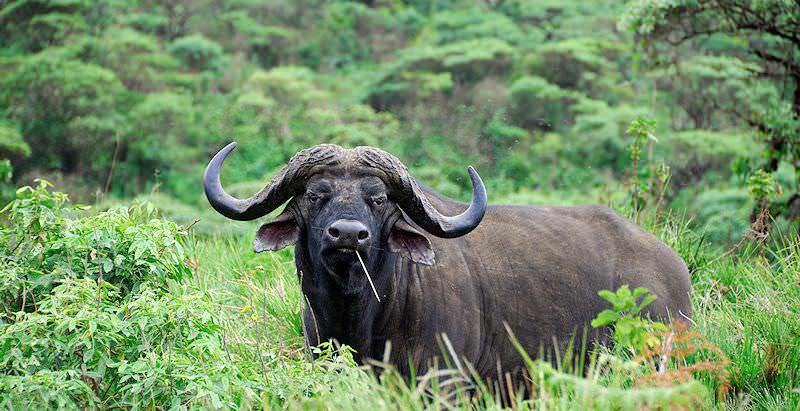

In [19]:
buffalo = list(data_dir.glob('buffalo/*'))
PIL.Image.open(str(buffalo[0]))

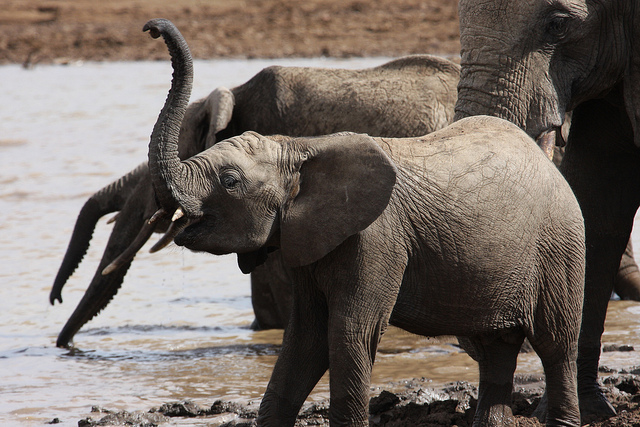

In [20]:
elephant = list(data_dir.glob('elephant/*.jpg'))
PIL.Image.open(str(elephant[1]))

#### Load using keras.preprocessing

Let us load this images off disk using the image_dataset_from_directory utility. This will take us from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

In [21]:
#Creating a dataset
batch_size =  32
img_height = 160
img_width = 160

It is always a good practice to use a validation split when developing a model. We will use 80% of the images for training, and 20% for validation.

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1483 files belonging to 4 classes.
Using 1187 files for training.


In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 1483 files belonging to 4 classes.
Using 296 files for validation.


In [24]:
#You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['buffalo', 'elephant', 'rhino', 'zebra']


#### Data cleaning
removing corrupted , unsupported formart files

In [25]:
from pathlib import Path
import imghdr
import shutil
destination_folder_path = 'C:/Users/Chigerwe/Desktop/ml&nn/corrtupted_files/'
data_dir = 'C:/Users/Chigerwe/Desktop/ml&nn/few_african_animals/'
image_extensions = [".png", ".jpg", 'bmp', 'jpeg']  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        destination_file_path = os.path.join(destination_folder_path, os.path.basename(filepath))
        if img_type is None:
            print(f"{filepath} is not an image")
            shutil.move(filepath, destination_file_path)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            shutil.move(filepath, destination_file_path)

In [26]:
import os
import cv2
import imghdr
#https://discuss.tensorflow.org/t/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required-tensorflow-error/16323
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list = os.listdir(klass_path)
            for f in file_list:   
                f_path = os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img = cv2.imread(f_path)
                        shape = img.shape
                    except Exception:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext
source_dir = 'C:/Users/Chigerwe/Desktop/ml&nn/few_african_animals/'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ]
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) != 0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print('no improper image files were found')

processing class directory  buffalo


processing class directory  elephant
processing class directory  rhino
processing class directory  zebra
no improper image files were found


Configure the dataset for performance

Now, to use buffered prefetching so we can yield data from disk without having I/O become blocking. These two important methods should be used while loading data

Dataset.cache() keeps the images in memory after they are loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your datset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [27]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

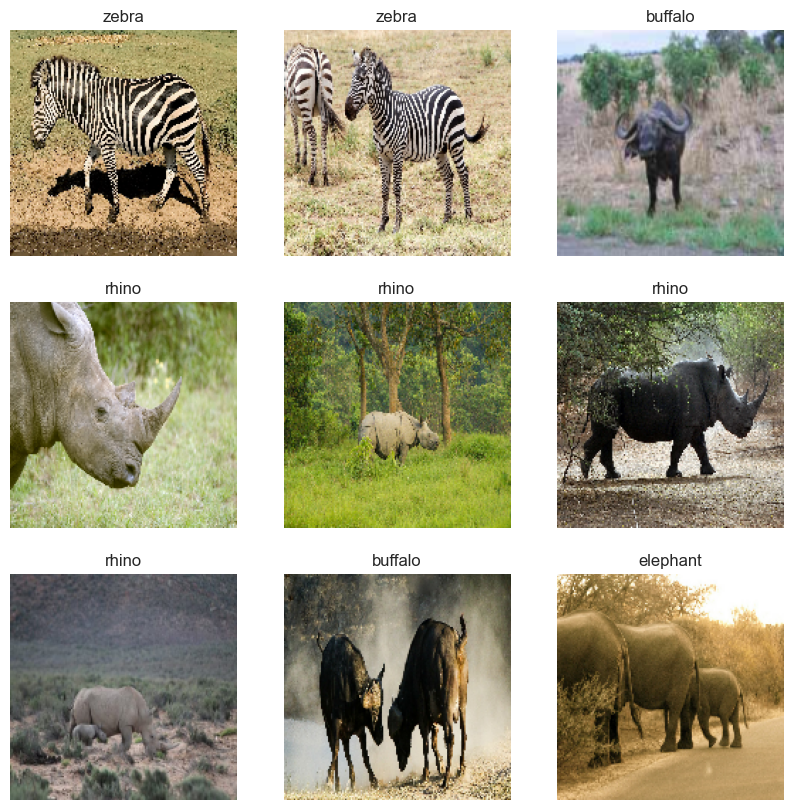

In [28]:
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [29]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 160, 160, 3)
(32,)


In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(32000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standarize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make our input values small. Now we will standarize the values to be in the [0,1] by using Rescaling layer.

In [31]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [32]:
#There are two ways to use this layer. We can apply it to the dataset by calling map:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


we can include the layer inside our model definition, whhich can simplify deployment. We will use second approach below.

**Create the model**

The model consists of three convolutional blocks with a max pool layer in each of them. There is a fully connected layers with 128 units on top of it that is activated by relu activation function. This model has not been tuned for high accuracy, the goal is to show a standard approach.

In [33]:
num_classes = 4
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile the model**

We chose the optimaer.Adam optimiazer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics arguement.

**Model Summary**

This views all the layers of the network using the model's summary method



In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1

**Train the model**

In [35]:
epochs=9
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/9


38/38 [==============================] - 100s 3s/step - loss: 1.2737 - accuracy: 0.4162 - val_loss: 0.9528 - val_accuracy: 0.5946
Epoch 2/9
38/38 [==============================] - 95s 3s/step - loss: 0.9006 - accuracy: 0.6032 - val_loss: 0.7395 - val_accuracy: 0.7128
Epoch 3/9
38/38 [==============================] - 99s 3s/step - loss: 0.6670 - accuracy: 0.7220 - val_loss: 0.7212 - val_accuracy: 0.7128
Epoch 4/9
38/38 [==============================] - 96s 3s/step - loss: 0.5318 - accuracy: 0.7961 - val_loss: 0.7403 - val_accuracy: 0.7095
Epoch 5/9
38/38 [==============================] - 113s 3s/step - loss: 0.4333 - accuracy: 0.8458 - val_loss: 0.7667 - val_accuracy: 0.7027
Epoch 6/9
38/38 [==============================] - 111s 3s/step - loss: 0.3386 - accuracy: 0.8770 - val_loss: 0.7608 - val_accuracy: 0.7432
Epoch 7/9
38/38 [==============================] - 101s 3s/step - loss: 0.2229 - accuracy: 0.9309 - val_loss: 1.0576 - val_accuracy: 0.6858
Epoch 8/9
38/38 [================

In [36]:
model.save("african_dataset.h5")

c:\Users\Chigerwe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Visualize training results**

Create plots of loss and accuracy on the training and validation sets.

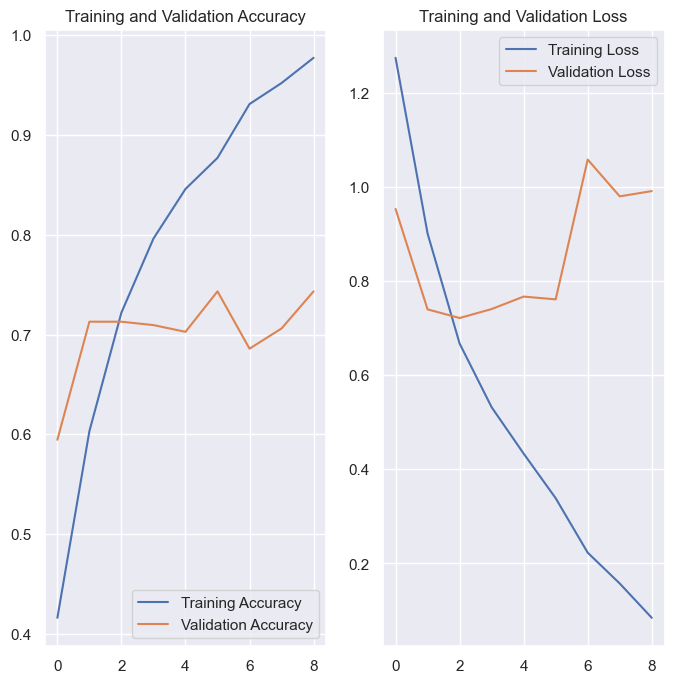

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see from the plots, training accuracy and validation accuracy are off by large margin.

**Overfitting**

In the plot above, the training accuracy is increasing lineraly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable which is a sign of overfitting.

When there are a small number of training exapmles, the model sometimes learns from noises or unwanted details from training examples - to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new datset.

There are multiple ways to fight overfitting in the training process. Here, we will be using data augmentation and Dropout concept in our model.

**Data augmentation**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental Keras Preprocessing Layers. These can be included inside your model like other layers and run on the GPU

In [38]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let us visualize what a few augmented examples look like applying data augmentation to the same image several times:

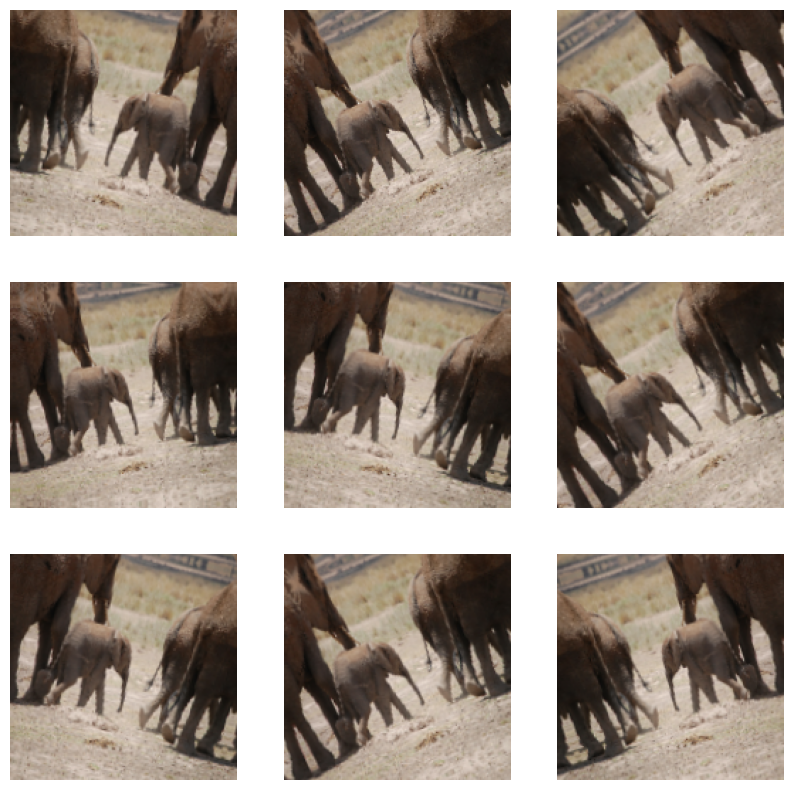

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Dropout**

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1,0.2,0.4 etc. This means dropping out 10% 20% or 40% of the output units randomly from the applied layer.

In [40]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 80, 80, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                 

In [43]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
38/38 [==============================] - 185s 5s/step - loss: 1.3903 - accuracy: 0.3252 - val_loss: 1.3924 - val_accuracy: 0.2838
Epoch 2/15
38/38 [==============================] - 144s 4s/step - loss: 1.0550 - accuracy: 0.5072 - val_loss: 1.0523 - val_accuracy: 0.6115
Epoch 3/15
38/38 [==============================] - 147s 4s/step - loss: 0.8972 - accuracy: 0.6049 - val_loss: 1.6754 - val_accuracy: 0.5541
Epoch 4/15
38/38 [==============================] - 143s 4s/step - loss: 0.8637 - accuracy: 0.6310 - val_loss: 0.9203 - val_accuracy: 0.6520
Epoch 5/15
38/38 [==============================] - 181s 5s/step - loss: 0.8150 - accuracy: 0.6580 - val_loss: 1.1671 - val_accuracy: 0.6791
Epoch 6/15
38/38 [==============================] - 156s 4s/step - loss: 0.7890 - accuracy: 0.6563 - val_loss: 1.4594 - val_accuracy: 0.5946
Epoch 7/15
38/38 [==============================] - 134s 4s/step - loss: 0.7306 - accuracy: 0.6883 - val_loss: 1.4427 - val_accuracy: 0.6351
Epoch 8/15
38

Visualize training result

After applying data augmentation and dropout, there is less overfitting than before and training and validation accuracy are closer aligned.

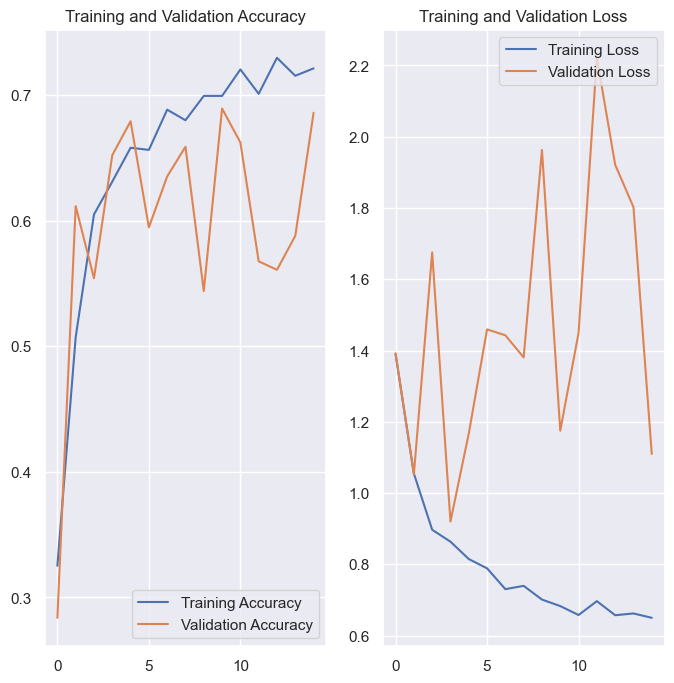

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Predict on new data**

In [ ]:
#!pip install scikit-image

In [50]:
#from skimage import io
import cv2

In [56]:
img = keras.preprocessing.image.load_img(
    "C:/Users/Chigerwe/Desktop/ml&nn/03ac351ca0.jpg", target_size=(img_height, img_width)
)

In [57]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 96ms/step


This image most likely belongs to zebra with a 100.00 percent confidence.
